In [74]:
import sqlite3
import pandas as pd
import matplotlib as rc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [75]:
#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
#------------------------------------------------------------------------------
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# set style for seaborn
sns.set_style("whitegrid")
sns.set_context("paper")

WIDTH = 5.8
SMALL_HEIGHT = 3
MEDIUM_HEIGHT = 5
BIGGER_HEIGHT = 7

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

OUTPUT = "../output/graph/"


In [76]:
# connect to database
connection = sqlite3.connect("../output/db/bulk_analysis_2019-11-08_1000ms.db")


In [85]:
# load games and moves into dataframes 
df_game_dirty = pd.read_sql("SELECT * FROM game", connection)
df_move_dirty = pd.read_sql("SELECT id, game_id, ply_number, threats_count_all as total, unopposed_threats_count_all as unopposed, (threats_count_all-unopposed_threats_count_all) as defended, pin_count_all as pin, skewer_count_all as skewer, fork_count_all as fork  FROM move", connection)
df_move_avg_dirty = pd.read_sql("SELECT id, game_id, ply_number, avg(threats_count_all) as threats_count_all, avg(unopposed_threats_count_all) as unopposed_threats_count_all, avg(threats_count_all-unopposed_threats_count_all) as defended_threats_count_all, avg(pin_count_all) as pin_count_all, avg(skewer_count_all) as skewer_count_all, avg(fork_count_all) as fork_count_all FROM move GROUP BY ply_number;", connection)

# remove games that are either too short or too long
df_game = remove_outlier(df_game_dirty, "length")
df_move = df_move_dirty.query("ply_number <= 133")
df_move_avg = df_move_avg_dirty.query("ply_number <= 133")


In [86]:
# df_move.apply(lambda row: row.threats_count_all - row.unopposed_threats_count_all, axis=1)
# df_move["defended_threats_count_all"] = df_move.apply(lambda row: row.threats_count_all - row.unopposed_threats_count_all, axis=1)


In [88]:
df_move_melted = pd.melt(df_move, id_vars=["id", "ply_number"], value_vars=["total", "unopposed", "defended", "pin", "skewer", "fork"])
df_move_melted.head()


,id,ply_number,variable,value
0,1,1,total,0
1,2,2,total,0
2,3,3,total,0
3,4,4,total,0
4,5,5,total,0


Text(0, 0.5, 'mean no. of threats')

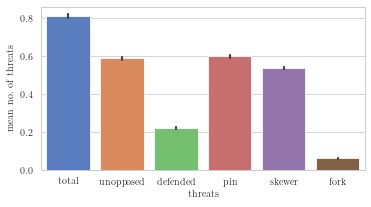

In [89]:
plt.figure(figsize=(WIDTH, SMALL_HEIGHT))
cat_threats = sns.barplot(x="variable", y="value", data=df_move_melted, palette="muted")
cat_threats.set_xlabel("threats")
cat_threats.set_ylabel("mean no. of threats")
#cat_threats.set_xticklabelss()
#plt.show()

In [90]:
fig = cat_threats.get_figure()
fig.tight_layout()
fig.savefig(OUTPUT+"bar_threats.pdf")



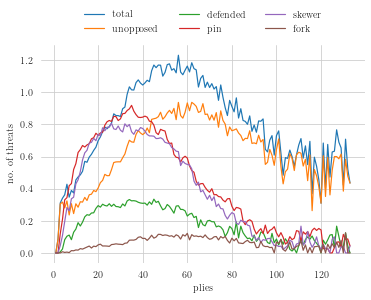

In [97]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(WIDTH, 4))
# Plot the total crashes
sns.set_color_codes("pastel")
sns.lineplot(x="ply_number", y="threats_count_all", data=df_move_avg,
            label="total")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.lineplot(x="ply_number", y="unopposed_threats_count_all", data=df_move_avg,
            label="unopposed")

sns.set_color_codes("muted")
sns.lineplot(x="ply_number", y="defended_threats_count_all", data=df_move_avg,
            label="defended")

sns.lineplot(x="ply_number", y="pin_count_all", data=df_move_avg,
            label="pin")

sns.lineplot(x="ply_number", y="skewer_count_all", data=df_move_avg,
            label="skewer")

sns.lineplot(x="ply_number", y="fork_count_all", data=df_move_avg,
            label="fork")
# Add a legend and informative axis label
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)
ax.set(ylabel="no. of threats",
       xlabel="plies")
sns.despine(left=True, bottom=True)

In [98]:
f.tight_layout()
f.savefig(OUTPUT+"line_threats.pdf")


